<a href="https://colab.research.google.com/github/Gio99c/GCR/blob/master/GCR_Latent_conditional_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone the repository and install dependecies

In [5]:
%%capture
!git clone https://github.com/Gio99c/GRC.git
%cd GRC/main
!pip install hydra
!pip install torchdiffeq
!pip install hydra-core
!pip install pytorch-lightning
!pip install wget

## GCR setup

In [ ]:
%%capture
import os
import sys
import torch
import torchvision as tv
p = os.path.join(os.path.abspath("."), "")
sys.path.insert(1, p)
p = os.path.join(os.path.abspath("."), "lace")
sys.path.insert(2, p)

from util import dotdict
import wget
from models.vae import VAE
from models.diffusion import DDPM, DDPMv2, DDPMWrapper, SuperResModel, UNetModel
from datasets import CIFAR10Dataset
from datasets.latent import LatentDataset
from lace.sampling import _sample_q_dict
from lace.eval_sampler import ConditionalSampling
import copy
import hydra
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from models.callbacks import ImageWriter
from torch.utils.data import DataLoader
from util import configure_device
from models.diffusion.classifier import mobilenet_v2
from models.diffusion.gcr import GCR
from PIL import Image
from IPython.utils.py3compat import cast_bytes

device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

sqrt = lambda x: int(torch.sqrt(torch.Tensor([x])))
plot = lambda p, x: tv.utils.save_image(torch.clamp(x, -1, 1), p, normalize=False, nrow=sqrt(x.size(0)))


## Load pretrained classifier
state_dict_clf = torch.load("./models/diffusion/state_dicts/mobilenet_v2.pt")
clf = mobilenet_v2(pretrained=True, progress=True, device=torch.device('cuda'))
clf.load_state_dict(state_dict_clf)
clf.eval()


## Download pretrained VAE
wget.download("https://drive.google.com/u/0/uc?id=1_UODuLoAhgAmxxMfNP5tG2ovJiRMGVS2&export=download&confirm=t&uuid=8e4b55c8-560a-4e59-86d1-de36667d5fe8&at=AHV7M3eUiPswRghe8ZrHKaWI8HK-:1670561868660", "./models/diffusion/state_dicts/vae_cifar10.ckpt")
vae = VAE.load_from_checkpoint("./models/diffusion/state_dicts/vae_cifar10.ckpt", input_res=32)
vae.eval()

## Download pretrained DiffuseVAE
wget.download("https://drive.google.com/u/0/uc?id=1QXVvJ0XyrPyD4hQr09B1gEVGzhmn2IuY&export=download&confirm=t&uuid=3869ccd1-8848-4e86-b997-ed082fc5ee3f&at=AHV7M3eK3aMh3gARBEJR50j0ECH4:1670562425982", "./models/diffusion/state_dicts/diffusevae_cifar10.ckpt")
config = dotdict(
    {'dataset': dotdict(
        {'ddpm': dotdict(
            {'data': dotdict(
                {'root': '???', 'name': 'cifar10', 'image_size': 32, 'hflip': True, 'n_channels': 3, 'norm': True, 'ddpm_latent_path': ''}), 'model': dotdict(
                    {'dim': 160, 'attn_resolutions': '16,', 'n_residual': 3, 'dim_mults': '1,2,2,2', 'dropout': 0.3, 'n_heads': 8, 'beta1': 0.0001, 'beta2': 0.02, 'n_timesteps': 1000}), 'evaluation': dotdict(
                        {'chkpt_path': './models/diffusion/state_dicts/diffusevae_cifar10.ckpt', 'save_path': '.', 'z_cond': False, 'z_dim': 512, 'guidance_weight': 0.0, 'type': 'form1', 'resample_strategy': 'truncated', 'skip_strategy': 'quad', 'sample_method': 'ddpm', 'sample_from': 'target', 'seed': 0, 'device': 'gpu', 'n_samples': 2500, 'n_steps': 1, 'workers': 4, 'batch_size': 2, 'save_vae': True, 'variance': 'fixedlarge', 'sample_prefix': 'gpu_1', 'temp': 1.0, 'save_mode': 'image'}), 'interpolation': dotdict(
                            {'n_steps': 10})}), 'vae': dotdict({'data': dotdict({'root': '???', 'name': 'cifar10', 'image_size': 32, 'n_channels': 3}), 'model': dotdict({'z_dim': 512, 'enc_block_config': '32x7,32d2,32t16,16x4,16d2,16t8,8x4,8d2,8t4,4x3,4d4,4t1,1x3', 'enc_channel_config': '32:64,16:128,8:256,4:256,1:512', 'dec_block_config': '1x1,1u4,1t4,4x2,4u2,4t8,8x3,8u2,8t16,16x7,16u2,16t32,32x15', 'dec_channel_config': '32:64,16:128,8:256,4:256,1:512'}), 'evaluation': dotdict(
                                {'chkpt_path': './models/diffusion/state_dicts/vae_cifar10.ckpt', 'save_path': '???', 'expde_model_path': '', 'seed': 0, 'device': 'gpu', 'workers': 2, 'batch_size': 8, 'n_samples': 50000, 'sample_prefix': '', 'save_mode': 'image'})})})})

def __parse_str(s):
    split = s.split(",")
    return [int(s) for s in split if s != "" and s is not None]


# Seed and setup
config_ddpm = config.dataset.ddpm
config_vae = config.dataset.vae
seed_everything(config_ddpm.evaluation.seed, workers=True)

batch_size = 256
n_steps = config_ddpm.evaluation.n_steps
n_samples = config_ddpm.evaluation.n_samples
image_size = config_ddpm.data.image_size
ddpm_latent_path = config_ddpm.data.ddpm_latent_path
ddpm_latents = torch.load(ddpm_latent_path) if ddpm_latent_path != "" else None

# Load pretrained VAE
vae = VAE.load_from_checkpoint(
    config_vae.evaluation.chkpt_path,
    input_res=image_size,
).cuda()
vae.eval()

# Load pretrained wrapper
attn_resolutions = __parse_str(config_ddpm.model.attn_resolutions)
dim_mults = __parse_str(config_ddpm.model.dim_mults)
decoder = SuperResModel(
    in_channels=config_ddpm.data.n_channels,
    model_channels=config_ddpm.model.dim,
    out_channels=3,
    num_res_blocks=config_ddpm.model.n_residual,
    attention_resolutions=attn_resolutions,
    channel_mult=dim_mults,
    use_checkpoint=False,
    dropout=config_ddpm.model.dropout,
    num_heads=config_ddpm.model.n_heads,
    z_dim=config_ddpm.evaluation.z_dim,
    use_scale_shift_norm=config_ddpm.evaluation.z_cond,
    use_z=config_ddpm.evaluation.z_cond,
)

ema_decoder = copy.deepcopy(decoder)
decoder.eval()
ema_decoder.eval()

ddpm_cls = DDPMv2 if config_ddpm.evaluation.type == "form2" else DDPM
online_ddpm = ddpm_cls(
    decoder,
    beta_1=config_ddpm.model.beta1,
    beta_2=config_ddpm.model.beta2,
    T=config_ddpm.model.n_timesteps,
    var_type=config_ddpm.evaluation.variance,
)
target_ddpm = ddpm_cls(
    ema_decoder,
    beta_1=config_ddpm.model.beta1,
    beta_2=config_ddpm.model.beta2,
    T=config_ddpm.model.n_timesteps,
    var_type=config_ddpm.evaluation.variance,
)

ddpm_wrapper = DDPMWrapper.load_from_checkpoint(
    config_ddpm.evaluation.chkpt_path,
    online_network=online_ddpm,
    target_network=target_ddpm,
    vae=vae,
    conditional=True,
    pred_steps=n_steps,
    eval_mode="sample",
    resample_strategy=config_ddpm.evaluation.resample_strategy,
    skip_strategy=config_ddpm.evaluation.skip_strategy,
    sample_method=config_ddpm.evaluation.sample_method,
    sample_from=config_ddpm.evaluation.sample_from,
    data_norm=config_ddpm.data.norm,
    temp=config_ddpm.evaluation.temp,
    guidance_weight=config_ddpm.evaluation.guidance_weight,
    z_cond=config_ddpm.evaluation.z_cond,
    strict=True,
    ddpm_latents=ddpm_latents,
)


model = GCR(ddpm_wrapper.to(device), clf.to(device), config_vae.model.z_dim)

# Create predict dataset of latents
z_dataset = LatentDataset(
    (n_samples, config_vae.model.z_dim, 1, 1),
    (n_samples, 3, image_size, image_size),
    share_ddpm_latent=True if ddpm_latent_path != "" else False,
    expde_model_path=config_vae.evaluation.expde_model_path,
    seed=config_ddpm.evaluation.seed,
)

# Setup devices
test_kwargs = {}
loader_kws = {}
device = 'cuda'
if torch.cuda.is_available():
    test_kwargs['accelerator'] = "gpu"
    test_kwargs["gpus"] = 1
    

    # Disable find_unused_parameters when using DDP training for performance reasons
    loader_kws["persistent_workers"] = True


# Predict loader
#pin_memory commented
val_loader = DataLoader(
    z_dataset,
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    pin_memory=True,
    num_workers=config_ddpm.evaluation.workers,
    **loader_kws,
)

# Predict trainer
write_callback = ImageWriter(
    config_ddpm.evaluation.save_path,
    "batch",
    n_steps=n_steps,
    eval_mode="sample",
    conditional=True,
    sample_prefix=config_ddpm.evaluation.sample_prefix,
    save_vae=config_ddpm.evaluation.save_vae,
    save_mode=config_ddpm.evaluation.save_mode,
    is_norm=config_ddpm.data.norm,
)


## Conditional generation

Select the class for conditional generation (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck): airplane
Do you want to perform single or double sampling? (just type 'single' or 'double'): double
#ODE steps for 0: 482
#ODE steps for 0: 206
Batch 0


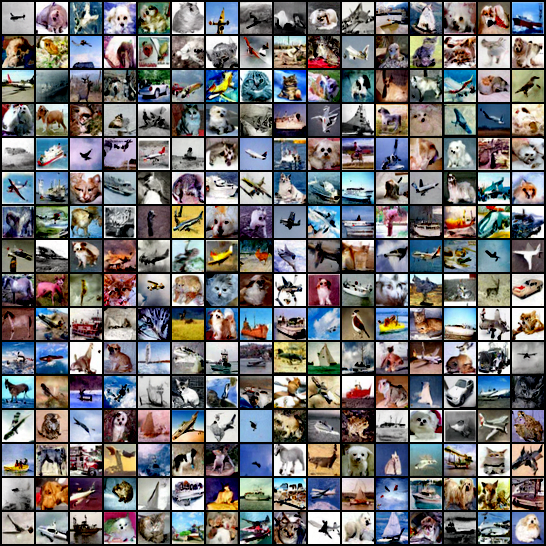

#ODE steps for 0: 524
#ODE steps for 0: 212
Batch 1


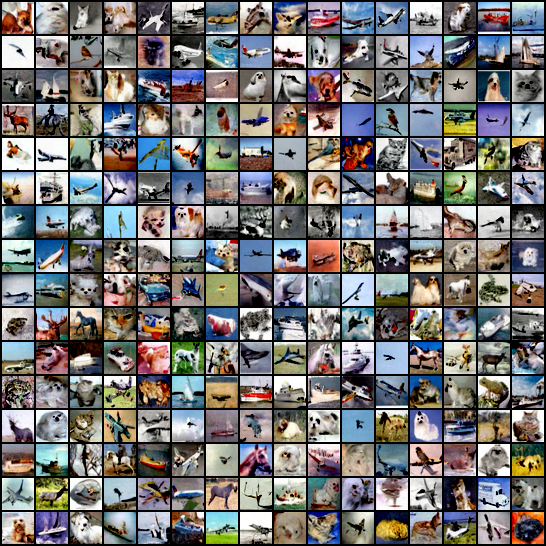

#ODE steps for 0: 470
#ODE steps for 0: 206
Batch 2


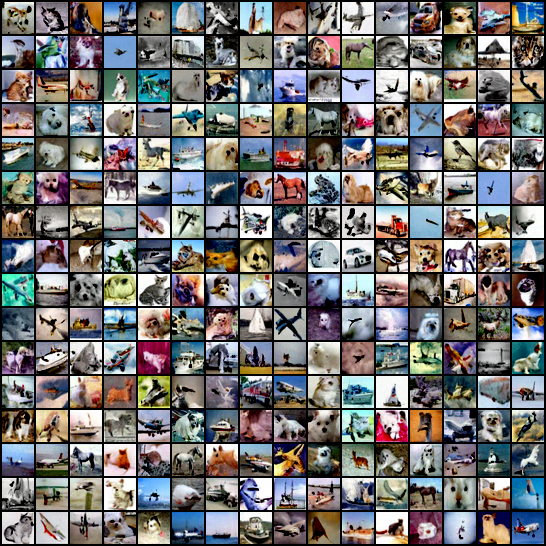

#ODE steps for 0: 464
#ODE steps for 0: 230
Batch 3


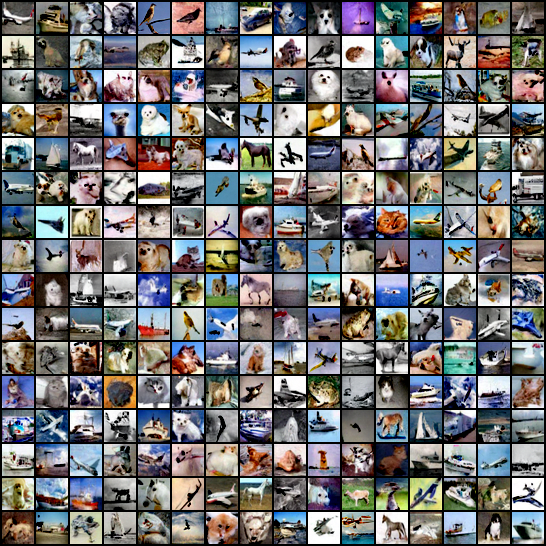

#ODE steps for 0: 428
#ODE steps for 0: 206
Batch 4


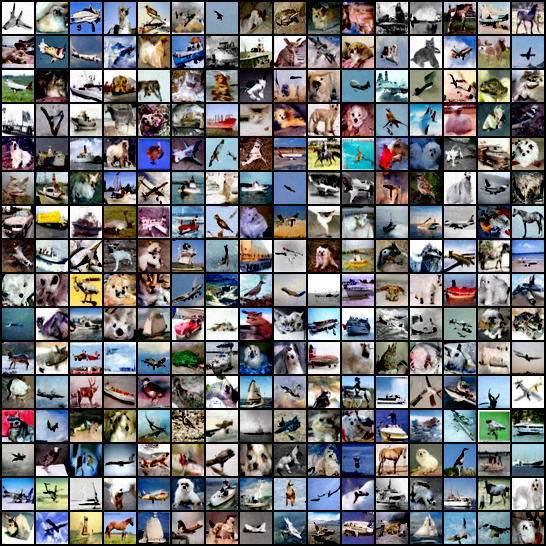

#ODE steps for 0: 494
#ODE steps for 0: 200
Batch 5


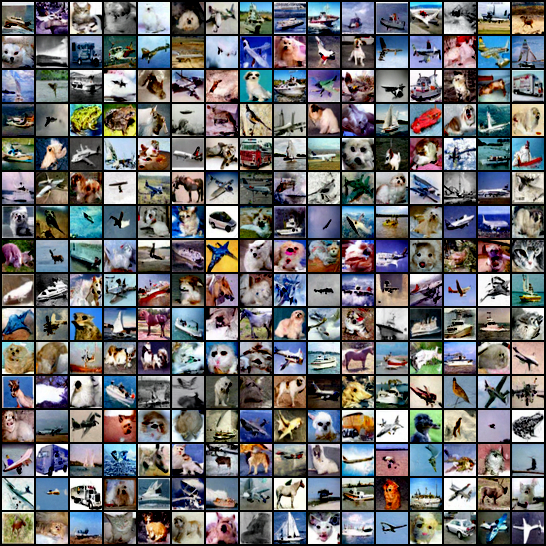

#ODE steps for 0: 434
#ODE steps for 0: 218
Batch 6


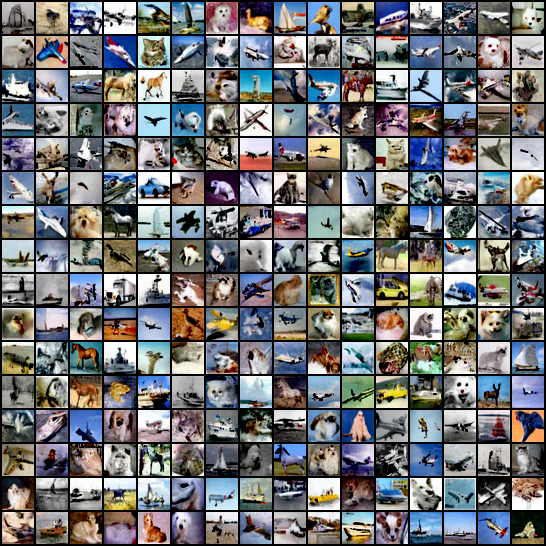

#ODE steps for 0: 440
#ODE steps for 0: 230
Batch 7


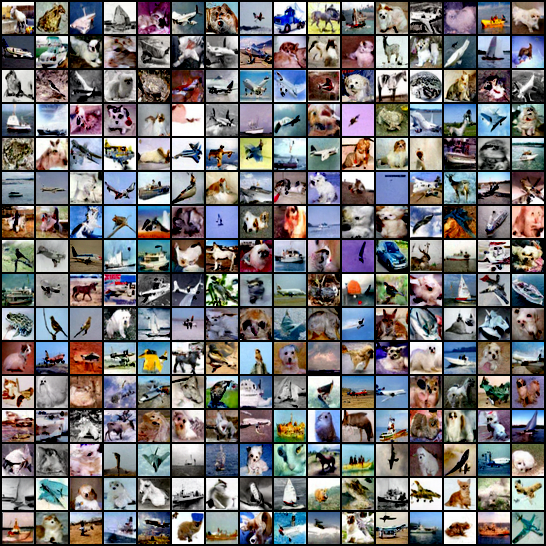

#ODE steps for 0: 476
#ODE steps for 0: 194
Batch 8


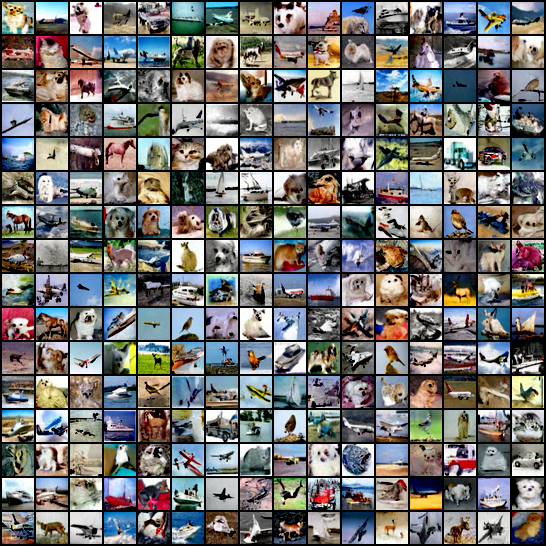

RuntimeError: ignored

In [7]:
category = "airplane" #@param ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
latent_sampling = "double" #@param ["single", "double"]
tollerance = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

sample_q = _sample_q_dict["sample_q_ode"]
ode_kwargs = {'atol': tollerance, 'rtol': tollerance, 'method': "dopri5", 'use_adjoint': True}
ld_kwargs = {'batch_size': batch_size, 'latent_dim': config_vae.model.z_dim, 'sgld_lr': 1,
                'sgld_std': 1e-2, 'n_steps': 1}
sde_kwargs = {'N': 100, 'correct_nsteps': 2, 'target_snr': 0.16}

n_classes = 10

condSampling = ConditionalSampling(sample_q, 256, config_vae.model.z_dim, n_classes, model,
                                    device, ".", ode_kwargs, ld_kwargs, sde_kwargs,
                                    every_n_plot=1)


classes = {"airplane": 0, "automobile": 1, "bird": 2, "cat": 3, "deer": 4, "dog": 5, "frog": 6, "horse": 7, "ship": 8, "truck": 9}
sampling = {"single": False, "double": True}

j = classes[category]
double = sampling[latent_sampling]
print(f"Conditional {latent_sampling} latent sampling for class {category}")
for i, (x_t, z) in enumerate(val_loader):
  x_t = x_t.to(device)
  z = z.to(device)
  torch.set_grad_enabled(False)
  model.g.init_lace(c=torch.ones((1), dtype=torch.int64, device=device) * j, sampler=condSampling, double=double)
  img = model.g(x=x_t, z=z, n_steps=1000)['1000']
  plot(f"./batch{i}.png", img)
  print(f"Batch {i}")
  display(Image.open(f"./batch{i}.png"))